# Single series vs multi series forecasting

In univariate time series forecasting, a single time series is modeled as a linear or nonlinear combination of its lags. That is, the past values of the series are used to forecast its future. In multi-time series forecasting, two or more time series are modeled together using a single model.

¿Is it better to create a model for each series or a single one for all them?

## Libraries

In [32]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

/home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Data

In [13]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean'})

data.head()

,Demand,Temperature
Time,,
2011-12-31 14:00:00,8646.190700,21.225
2011-12-31 15:00:00,7926.529376,20.625
2011-12-31 16:00:00,7901.826990,20.325
2011-12-31 17:00:00,7255.721350,19.850
2011-12-31 18:00:00,6792.503352,19.025


In [14]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2014-06-01 00:00:00': '2014-07-31 23:59:00']
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates  : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


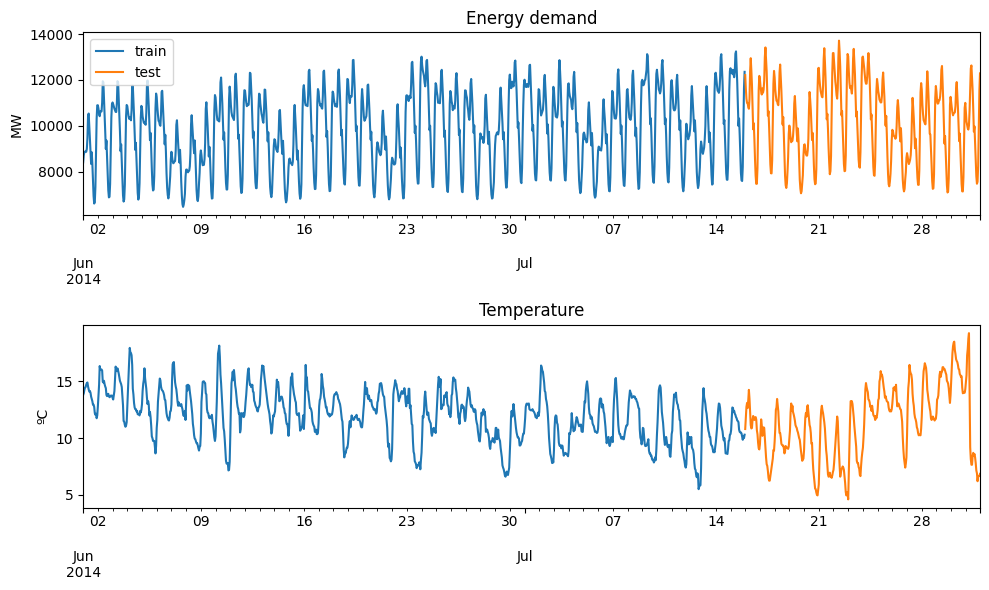

In [15]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_train['Demand'].plot(label='train', ax=axes[0])
data_test['Demand'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_train['Temperature'].plot(label='train', ax=axes[1])
data_test['Temperature'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

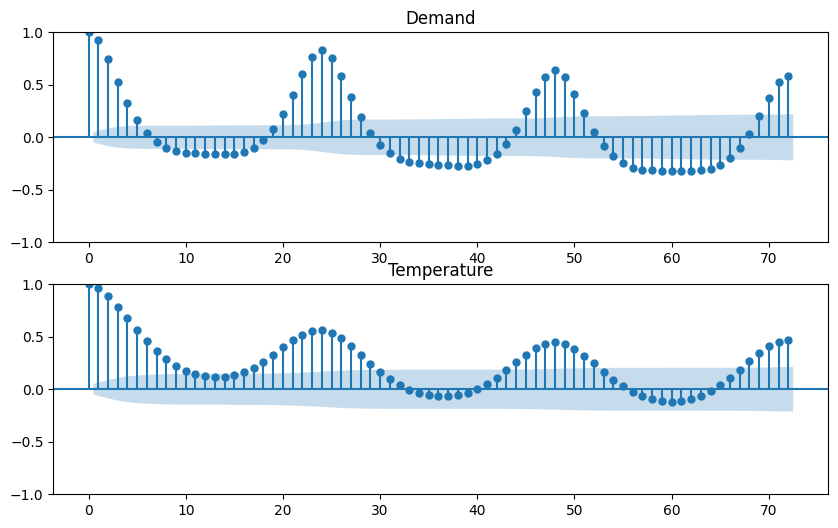

In [34]:
# Autocorrelation plot
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
plot_acf(data['Demand'], ax=axes[0], lags=72)
axes[0].set_title('Demand')
plot_acf(data['Temperature'], ax=axes[1], lags=72)
axes[1].set_title('Temperature')
plt.show()

## Multi series forecaster with linear models

For this first study, the forecasting performance of a multi-series forecaster (non multivariate) will be compared with the performance of single forecasters. For all them, a linear model will be use as regressor.

In [42]:
# ForecasterAutoreg with linear models
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor          = LinearRegression(),
                 lags               = 24,
                 transformer_y      = StandardScaler(),
                 transformer_exog   = None
             )

metric_demand, predictions_demand = backtesting_forecaster(
                                        forecaster         = forecaster,
                                        y                  = data['Demand'],
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps              = 24,
                                        metric             = 'mean_absolute_error',
                                        refit              = True,
                                        verbose            = False
                                )

metric_temperature, predictions_temperature = backtesting_forecaster(
                                                    forecaster         = forecaster,
                                                    y                  = data['Temperature'],
                                                    initial_train_size = len(data_train),
                                                    fixed_train_size   = True,
                                                    steps              = 24,
                                                    metric             = 'mean_absolute_error',
                                                    refit              = True,
                                                    verbose            = False
                                              )


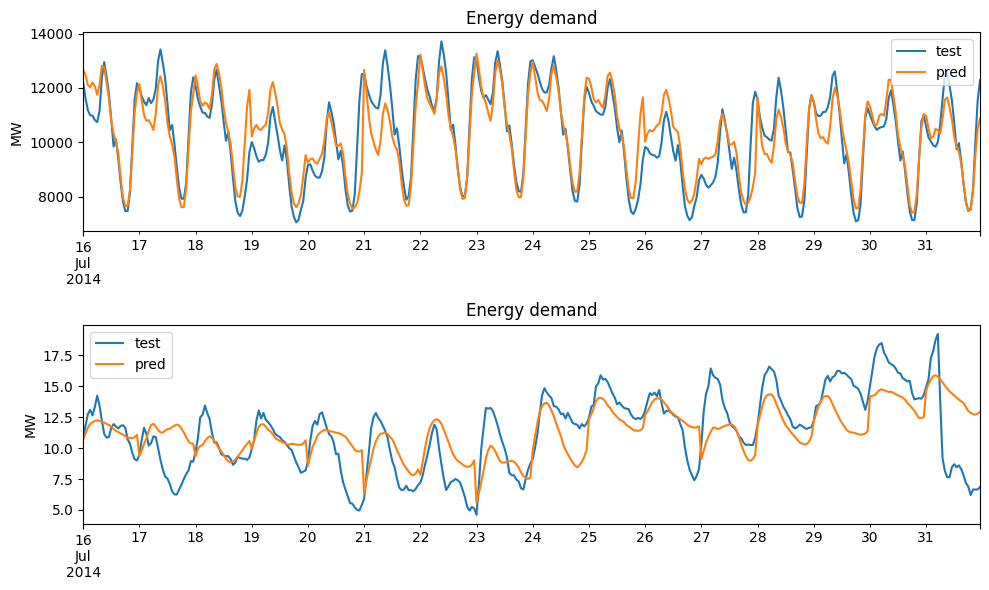

In [25]:
# Plot predictions
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(label='pred', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temperature.plot(label='pred', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')
axes[0].legend()

fig.tight_layout()
plt.show();

In [26]:
# Backtesting metrics
# ==============================================================================
print(f"Backtest error Demand: {metric_demand:.2f}")
print(f"Backtest error Temperature: {metric_temperature:.2f}")

Backtest error Demand: 571.22
Backtest error Temperature: 1.88


In [27]:
# ForecasterAutoregMultiSeries with linear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LinearRegression(),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None
             )

# Backtesting
# ==============================================================================
metric_demand, predictions_demand = backtesting_forecaster_multiseries(
                                          forecaster         = forecaster,
                                          series             = data[['Demand', 'Temperature']],
                                          level              = 'Demand',
                                          initial_train_size = len(data_train),
                                          fixed_train_size   = True,
                                          steps              = 24,
                                          metric             = 'mean_absolute_error',
                                          refit              = True,
                                          verbose            = False
                                    )

metric_temperature, predictions_temperature = backtesting_forecaster_multiseries(
                                                 forecaster         = forecaster,
                                                 series             = data[['Demand', 'Temperature']],
                                                 level              = 'Temperature',
                                                 initial_train_size = len(data_train),
                                                 fixed_train_size   = True,
                                                 steps              = 24,
                                                 metric             = 'mean_absolute_error',
                                                 refit              = True,
                                                 verbose            = False
                                              )

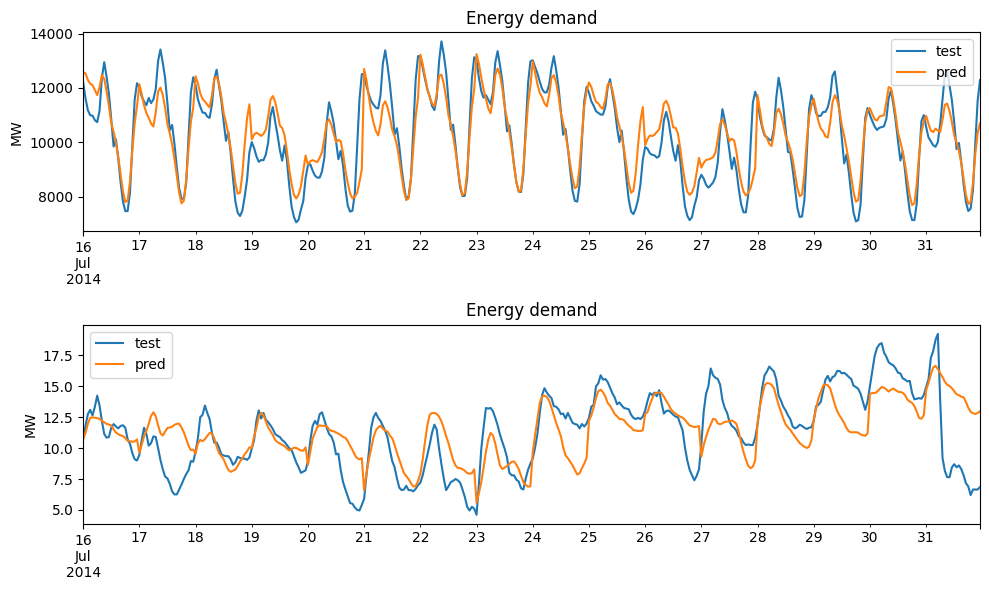

In [28]:
# Plot predictions
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(label='pred', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temperature.plot(label='pred', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')
axes[0].legend()

fig.tight_layout()
plt.show();

In [29]:
# Backtesting metrics
# ==============================================================================
print(f"Backtest error Demand: {metric_demand:.2f}")
print(f"Backtest error Temperature: {metric_temperature:.2f}")

Backtest error Demand: 571.41
Backtest error Temperature: 1.78


In this case, the performance of moth aproaches are very similar. So, the advantage of using a multi-series model is the simplicity of mantaining only one model instead of two.

In the previous example, both time series had a similar dynamic: the current value is highly correlated with the lags 1, 2, 3, 24, 48. What would happen if one the series do not share the same internal dynamics?

Train dates : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates  : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


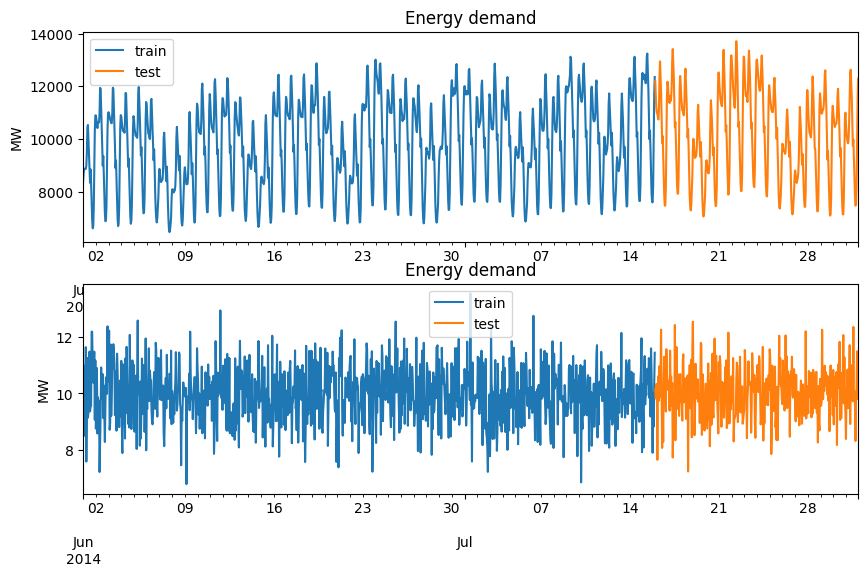

In [38]:
# Copy data and modify Temperature column as a normal distribution
# ==============================================================================
np.random.seed(123)
data_modified = data.copy()
data_modified['Temperature'] = np.random.normal(size=len(data_modified), loc=10, scale=1)

# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train_modified = data_modified.loc[:end_train, :].copy()
data_test_modified  = data_modified.loc[end_train:, :].copy()

print(f"Train dates : {data_train_modified.index.min()} --- {data_train_modified.index.max()}  (n={len(data_train_modified)})")
print(f"Test dates  : {data_test_modified.index.min()} --- {data_test_modified.index.max()}  (n={len(data_test_modified)})")

# Plot Temperature
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
data_train_modified['Demand'].plot(label='train', ax=axes[0])
data_test_modified['Demand'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_train_modified['Temperature'].plot(label='train', ax=axes[1])
data_test_modified['Temperature'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('MW')
axes[1].set_title('Energy demand')
axes[1].legend()
axes[1].legend()
plt.show();

In [39]:
# ForecasterAutoregMultiSeries with linear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LinearRegression(),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None
             )

# Backtesting
# ==============================================================================
metric_demand, predictions_demand = backtesting_forecaster_multiseries(
                                          forecaster         = forecaster,
                                          series             = data_modified[['Demand', 'Temperature']],
                                          level              = 'Demand',
                                          initial_train_size = len(data_train_modified),
                                          fixed_train_size   = True,
                                          steps              = 24,
                                          metric             = 'mean_absolute_error',
                                          refit              = True,
                                          verbose            = False
                                    )

In [41]:
# Backtesting metrics
# ==============================================================================
print(f"Backtest error Demand: {metric_demand:.2f}")

Backtest error Demand: 793.51


In [ ]:
The error when predicting demand has increased remarkably. This is due toooooooooooo

## Multi series forecaster with non linear models

The same experiment is repeated but this time using a non lineal model.

For this first study, the forecasting performance of a multi-series forecaster (non multivariate) will be compared with the performance of single forecasters. For all them, a linear model will be use as regressor.

In [43]:
# ForecasterAutoreg with non linear models
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor          = RandomForestRegressor(random_state=123),
                 lags               = 24,
                 transformer_y      = StandardScaler(),
                 transformer_exog   = None
             )

metric_demand, predictions_demand = backtesting_forecaster(
                                        forecaster         = forecaster,
                                        y                  = data['Demand'],
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps              = 24,
                                        metric             = 'mean_absolute_error',
                                        refit              = True,
                                        verbose            = False
                                )

metric_temperature, predictions_temperature = backtesting_forecaster(
                                                    forecaster         = forecaster,
                                                    y                  = data['Temperature'],
                                                    initial_train_size = len(data_train),
                                                    fixed_train_size   = True,
                                                    steps              = 24,
                                                    metric             = 'mean_absolute_error',
                                                    refit              = True,
                                                    verbose            = False
                                              )


In [45]:
# Backtesting metrics
# ==============================================================================
print(f"Backtest error Demand: {metric_demand:.2f}")
print(f"Backtest error Temperature: {metric_temperature:.2f}")

Backtest error Demand: 632.25
Backtest error Temperature: 2.18


In [46]:
# ForecasterAutoregMultiSeries with non linear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = RandomForestRegressor(random_state=123),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None
             )

# Backtesting
# ==============================================================================
metric_demand, predictions_demand = backtesting_forecaster_multiseries(
                                          forecaster         = forecaster,
                                          series             = data[['Demand', 'Temperature']],
                                          level              = 'Demand',
                                          initial_train_size = len(data_train),
                                          fixed_train_size   = True,
                                          steps              = 24,
                                          metric             = 'mean_absolute_error',
                                          refit              = True,
                                          verbose            = False
                                    )

metric_temperature, predictions_temperature = backtesting_forecaster_multiseries(
                                                 forecaster         = forecaster,
                                                 series             = data[['Demand', 'Temperature']],
                                                 level              = 'Temperature',
                                                 initial_train_size = len(data_train),
                                                 fixed_train_size   = True,
                                                 steps              = 24,
                                                 metric             = 'mean_absolute_error',
                                                 refit              = True,
                                                 verbose            = False
                                              )

In [47]:
# Backtesting metrics
# ==============================================================================
print(f"Backtest error Demand: {metric_demand:.2f}")
print(f"Backtest error Temperature: {metric_temperature:.2f}")

Backtest error Demand: 655.01
Backtest error Temperature: 2.02


Again, the performance of moth approaches are very similar. Let's see what happen if the resies do not share the same dinamycs.

In [49]:
# ForecasterAutoregMultiSeries with linear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = RandomForestRegressor(random_state=123),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None
             )

# Backtesting
# ==============================================================================
metric_demand, predictions_demand = backtesting_forecaster_multiseries(
                                          forecaster         = forecaster,
                                          series             = data_modified[['Demand', 'Temperature']],
                                          level              = 'Demand',
                                          initial_train_size = len(data_train_modified),
                                          fixed_train_size   = True,
                                          steps              = 24,
                                          metric             = 'mean_absolute_error',
                                          refit              = True,
                                          verbose            = False
                                    )

In [50]:
# Backtesting metrics
# ==============================================================================
print(f"Backtest error Demand: {metric_demand:.2f}")

Backtest error Demand: 625.93


When using a non linear model, the forecasting performance is not harmed even though the time series do not follow the same dinamycs. This is because the model is being able to identify that the series they have more differences than similarities, therefore, they are modeled almost separatelly.

One way to berify this hipothesis is to analyze how the threes of the model are created.

In [18]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>